[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RizanSM/zero_shot_llms_in_HIL_RL/blob/main/01_Code/01_Highway_Env/02_Default_Environment/04_BIASED_HF_RSM_AGG/01_Biased_HF_RSM_Policy_training_AGG.ipynb)

In [ ]:
# Install the required libraries in your Google Colab environment
!pip install stable-baselines3 gymnasium highway-env -q
# Install necessary packages
!pip install torch numpy pandas matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import highway_env
import os

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from google.colab import data_table
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 1: Load and Preprocess the Data
aggressive_df =  pd.read_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/02_data/02_trajectories/1_human_feedback/2_Biased_Hf_D_Aggressive_df.pkl')              # Update directory location 1

In [ ]:
# Display the data frame
data_table.enable_dataframe_formatter()
data_table.DataTable(aggressive_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Selecting relevant features and target
features = ['state', 'action', 'collision_flag', 'lane_index']
target = 'Recalibrated_rewards'

In [ ]:
# Convert features into tensor-compatible format
def process_features(df):
    # X = np.stack(df['state'].apply(lambda x: np.array(x)).values)  # Convert state to numpy array
    X = np.vstack(df['state'].apply(lambda x: np.array(x, dtype=np.float32)).values)  # Convert state to numpy array with float32 dtype
    # X = np.hstack([X, df[['action', 'collision_flag', 'lane_index']].values])
    X = np.hstack([X, df[['action', 'collision_flag', 'lane_index']].astype(np.float32).values])
    y = df[target].values
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X, y = process_features(aggressive_df)             # change here the dataframe name
print(X.shape)
print(y.shape)

torch.Size([3113, 28])
torch.Size([3113])


In [ ]:
# Split data into train and validation sets
train_size = int(0.8 * len(X))
val_size = len(X) - train_size
train_data, val_data = random_split(TensorDataset(X, y), [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [ ]:
# Step 2: Define the Reward Model (Neural Network) with Dropout and L2 Regularization
class RewardModel(nn.Module):
    def __init__(self, input_dim):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # Added Dropout

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after activation
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

# Initialize model
input_dim = X.shape[1]
print(input_dim)
model = RewardModel(input_dim)

# Define loss function and optimizer
criterion = nn.SmoothL1Loss()  # Replaced MSE with Huber Loss
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # Switched to AdamW and added L2 Regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)  # Added ReduceLROnPlateau

# Early stopping parameters
patience = 10  # Increased patience for early stopping
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

28


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.7259, Val Loss: 0.6836
Epoch [2/50], Train Loss: 0.6566, Val Loss: 0.6450
Epoch [3/50], Train Loss: 0.6293, Val Loss: 0.6219
Epoch [4/50], Train Loss: 0.6074, Val Loss: 0.5947
Epoch [5/50], Train Loss: 0.5802, Val Loss: 0.5748
Epoch [6/50], Train Loss: 0.5735, Val Loss: 0.5616
Epoch [7/50], Train Loss: 0.5676, Val Loss: 0.5596
Epoch [8/50], Train Loss: 0.5528, Val Loss: 0.5431
Epoch [9/50], Train Loss: 0.5452, Val Loss: 0.5371
Epoch [10/50], Train Loss: 0.5416, Val Loss: 0.5307
Epoch [11/50], Train Loss: 0.5363, Val Loss: 0.5283
Epoch [12/50], Train Loss: 0.5329, Val Loss: 0.5222
Epoch [13/50], Train Loss: 0.5329, Val Loss: 0.5214
Epoch [14/50], Train Loss: 0.5209, Val Loss: 0.5168
Epoch [15/50], Train Loss: 0.5259, Val Loss: 0.5066
Epoch [16/50], Train Loss: 0.5205, Val Loss: 0.5102
Epoch [17/50], Train Loss: 0.5210, Val Loss: 0.5063
Epoch [18/50], Train Loss: 0.5181, Val Loss: 0.5163
Epoch [19/50], Train Loss: 0.5150, Val Loss: 0.5038
Epoch [20/50], Train 

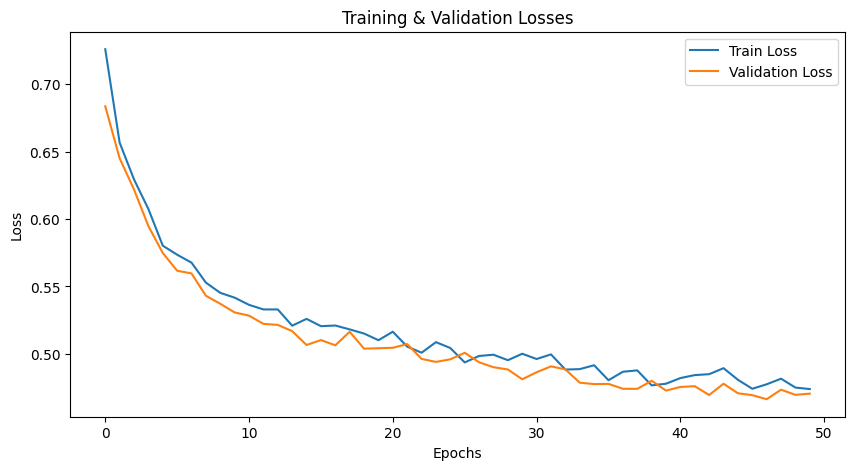

In [ ]:
# Step 3: Train the Reward Model with Early Stopping
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = sum(criterion(model(batch_X).squeeze(), batch_y).item() for batch_X, batch_y in val_loader) / len(val_loader)

    val_losses.append(val_loss)
    scheduler.step(val_loss)  # Apply learning rate scheduler
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping criteria
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Losses')
plt.show()

In [ ]:
# Step 4: Train PPO Using the Trained Reward Model

# Custom reward function using the trained reward model
def custom_reward(env, state):
    state_tensor = torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0)
    return model(state_tensor).item()

# Custom environment wrapper to replace environment reward with learned reward
class CustomHighwayEnv(gym.Wrapper):
    def __init__(self, env):
        super(CustomHighwayEnv, self).__init__(env)

    def step(self, action):
        next_state, _, done, truncated, info = self.env.step(action)
        reward = custom_reward(self.env, next_state)  # Use learned reward
        return next_state, reward, done, truncated, info


In [ ]:
# Step 4: Train PPO Using the Trained Reward Model

# Custom reward function using the trained reward model
def custom_reward(env, state):
    # Debugging: Print the state shape before processing
    # print("State shape before processing:", state.shape)

    # Reshape the state to match the expected input dimension of the RewardModel
    state_tensor = torch.tensor(state, dtype=torch.float32).reshape(1, -1)  # Reshape to (1, num_features)


    # Ensure the state tensor has the correct dimensions for the model
    input_dim = model.fc1.in_features  # Get expected input dimension from model
    if state_tensor.shape[1] < input_dim:
        padding = torch.zeros((1, input_dim - state_tensor.shape[1]))
        state_tensor = torch.cat([state_tensor, padding], dim=1)

    # Reshape to (1, num_features), and slice off any extra dimensions that are not expected.
    # state_tensor = torch.tensor(state, dtype=torch.float32).reshape(1, -1)[:, :input_dim]
    return model(state_tensor).item()

# Custom environment wrapper to replace environment reward with learned reward
class CustomHighwayEnv(gym.Wrapper):
    def __init__(self, env):
        super(CustomHighwayEnv, self).__init__(env)

    def step(self, action):
        next_state, _, done, truncated, info = self.env.step(action)
        reward = custom_reward(self.env, next_state)  # Use learned reward
        return next_state, reward, done, truncated, info

PPO training and Training logs

In [ ]:
# env = CustomHighwayEnv(gym.make('highway-v0'))
# env = DummyVecEnv([lambda: env])

In [ ]:
drive_log_dir = "/content/drive/MyDrive/05_zero_shot_llm_3/02_data/00_training_logs/4_log_dir/4_ppo_highway_biased_hf_lrs_aggressive"              # Update directory location 2

In [ ]:
# Train PPO with Custom Rewards
def train_ppo_with_custom_rewards(log_dir=drive_log_dir, total_timesteps=10000):
    os.makedirs(log_dir, exist_ok=True)
    env = CustomHighwayEnv(gym.make("highway-v0"))
    env = Monitor(env, log_dir)
    model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_dir)
    model.learn(total_timesteps=total_timesteps)
    model.save('/content/drive/MyDrive/05_zero_shot_llm_3/02_data/01_trained_models/4_ppo_highway_biased_hf_lrs_aggressive')       # Update directory location 3
    return model, log_dir

In [ ]:
# log_path = os.path.join(drive_log_dir, "monitor.csv")
# df = pd.read_csv(log_path, skiprows=1)
## Ensure episodes are logged correctly
# df.reset_index(inplace=True)
# df.rename(columns={"index": "episode", "r": "reward", "l": "length", "t": "time_step"}, inplace=True)

In [ ]:
# data_table.enable_dataframe_formatter()
# data_table.DataTable(df)

In [ ]:
# Execute Training and Convergence Tracking
model, log_dir = train_ppo_with_custom_rewards(total_timesteps=10000)

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to /content/drive/MyDrive/05_zero_shot_llm_3/02_data/00_training_logs/4_log_dir/4_ppo_highway_biased_hf_lrs_aggressive/PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | 20.4     |
| time/              |          |
|    fps             | 1        |
|    iterations      | 1        |
|    time_elapsed    | 1044     |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13.4        |
|    ep_rew_mean          | 24.9        |
| time/                   |             |
|    fps                  | 1           |
|    iterations           | 2           |
|    time_elapsed         | 2072        |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018728029 |
|    clip_fra